# <u>Objective</u>: To build and evaluate machine learning models for accurate stress level detection based on physiological signals.

## Importing required libraries

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,accuracy_score, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from catboost import CatBoostClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from prettytable import PrettyTable

## Loading Dataset

In [36]:
data = pd.read_csv(r"C:\Users\ASUS\Downloads\Datasets\data_stress.csv") 
df=pd.DataFrame(data)
# renaming the column name
df.columns=['snoring_rate', 'respiration_rate', 'body_temperature', 'limb_movement', 'blood_oxygen','eye_movement', 'sleeping_hours', 
             'heart_rate', 'stress_level']
df

,snoring_rate,respiration_rate,body_temperature,limb_movement,blood_oxygen,eye_movement,sleeping_hours,heart_rate,stress_level
0,93.800,25.680,91.840,16.600,89.840,99.60,1.840,74.20,3
1,91.640,25.104,91.552,15.880,89.552,98.88,1.552,72.76,3
2,60.000,20.000,96.000,10.000,95.000,85.00,7.000,60.00,1
3,85.760,23.536,90.768,13.920,88.768,96.92,0.768,68.84,3
4,48.120,17.248,97.872,6.496,96.248,72.48,8.248,53.12,0
...,...,...,...,...,...,...,...,...,...
625,69.600,46.500,92.960,10.960,90.960,89.80,NaN,62.40,2
626,48.440,17.376,98.064,6.752,96.376,73.76,8.376,53.44,0
627,97.504,27.504,86.880,17.752,84.256,101.88,0.000,78.76,4
628,58.640,19.728,95.728,9.728,94.592,84.32,6.728,59.32,1


## Data preprocessing

### Handling missing values

In [39]:
df.isnull().sum()

snoring_rate         0
respiration_rate     0
body_temperature    16
limb_movement       12
blood_oxygen         4
eye_movement        18
sleeping_hours      11
heart_rate          24
stress_level         0
dtype: int64

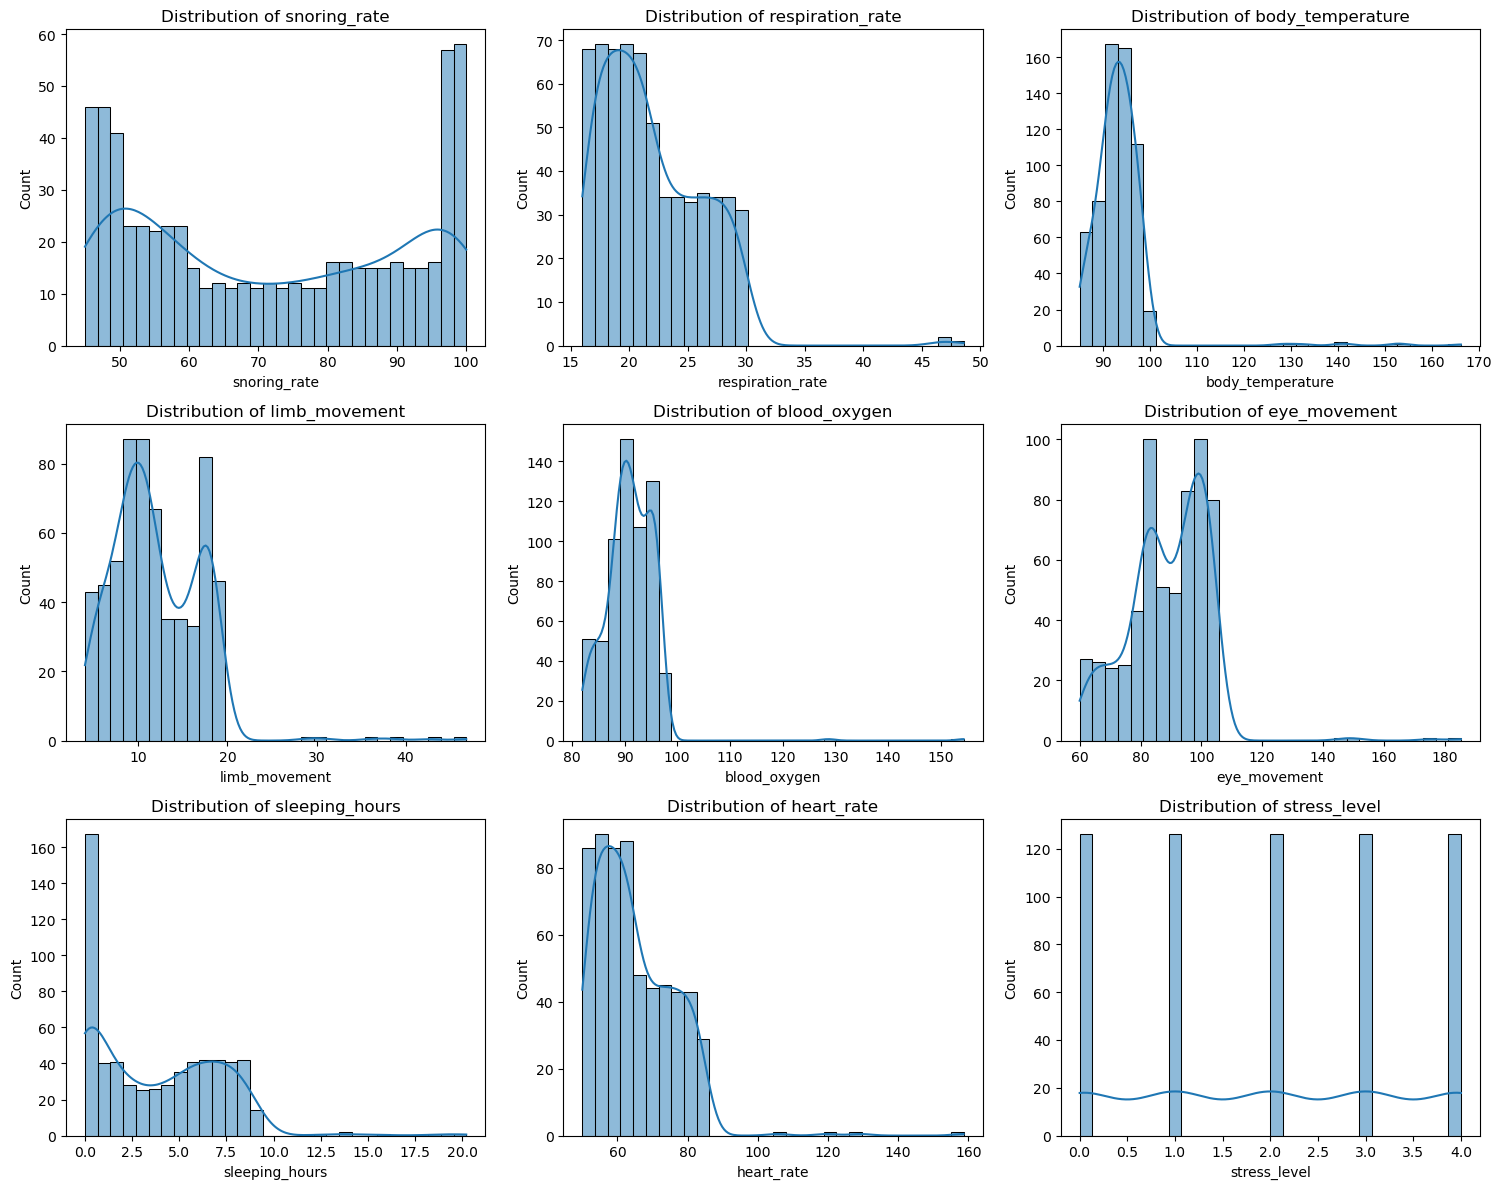

In [40]:
# Checkind sistribution of data

# Set plot size
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 12))
axes = axes.flatten()

# Plot each numerical column with histogram + KDE curve
for i, col in enumerate(df.select_dtypes(include="number").columns):
    sns.histplot(df[col], bins=30, kde=True, ax=axes[i])
    axes[i].set_title(f'Distribution of {col}')

# Adjust layout
plt.tight_layout()
plt.show()

##### Since attributes having missing values are highly skewed, therefore we use median to fill them.

In [42]:
df.fillna(df.median(numeric_only=True), inplace=True)

In [43]:
df.isnull().sum()

snoring_rate        0
respiration_rate    0
body_temperature    0
limb_movement       0
blood_oxygen        0
eye_movement        0
sleeping_hours      0
heart_rate          0
stress_level        0
dtype: int64

### Managing outliers

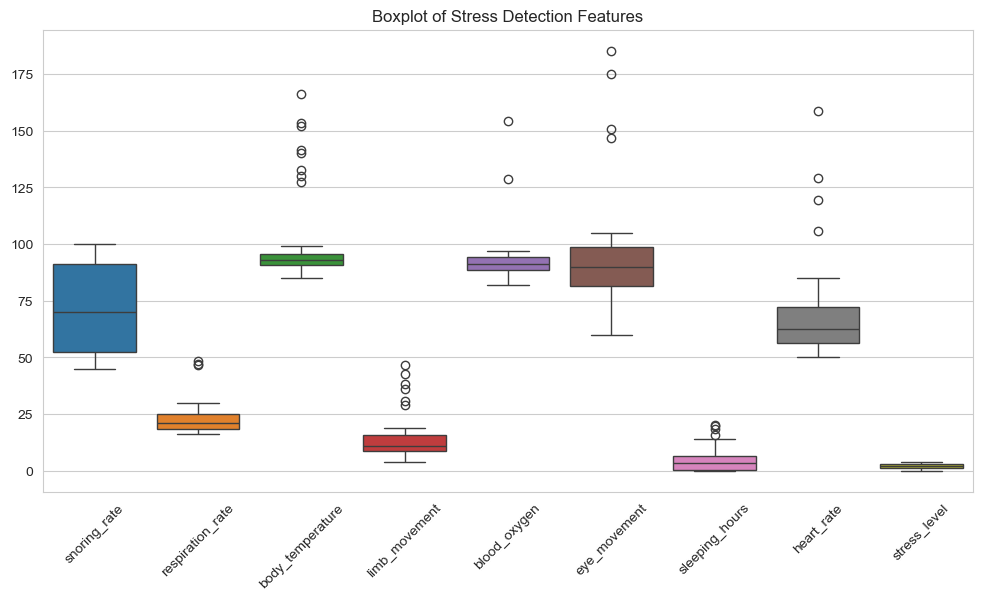

In [45]:
sns.set_style("whitegrid")
plt.figure(figsize=(12, 6))
sns.boxplot(data=df)
plt.xticks(rotation=45)
plt.title("Boxplot of Stress Detection Features")
plt.show()

##### There are many outliers! But for stress detection, physiological features are very important and they usually vary. So, these outliers play a vital role for our model, therefore we should keep them except for "body temperature", "eye movement", "blood oxygen", and "heart rate" because they have some unrealistic values.

In [47]:
# Outliers in body temperatue
Q1 = df["body_temperature"].quantile(0.25)
Q3 = df["body_temperature"].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outliers = df[(df["body_temperature"] < lower_bound) | (df["body_temperature"] > upper_bound)]
print("Number of outliers:", len(outliers))
# Transforming those outliers
df["body_temperature"] = np.clip(df["body_temperature"], lower_bound, upper_bound)
median_temp = df["body_temperature"].median()
df.loc[df["body_temperature"] > upper_bound, "body_temperature"] = median_temp
df.loc[df["body_temperature"] < lower_bound, "body_temperature"] = median_temp

Number of outliers: 8


In [48]:
# Outliers in eye movement
Q1 = df["eye_movement"].quantile(0.25)
Q3 = df["eye_movement"].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outliers = df[(df["eye_movement"] < lower_bound) | (df["eye_movement"] > upper_bound)]
print("Number of outliers:", len(outliers))
# Transforming those outliers
df["eye_movement"] = np.clip(df["eye_movement"], lower_bound, upper_bound)
median_eye_movement = df["eye_movement"].median()
df.loc[df["eye_movement"] > upper_bound, "eye_movement"] = median_eye_movement
df.loc[df["eye_movement"] < lower_bound, "eye_movement"] = median_eye_movement

Number of outliers: 4


In [49]:
# Outliers in blood oxygen
Q1 = df["blood_oxygen"].quantile(0.25)
Q3 = df["blood_oxygen"].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outliers = df[(df["blood_oxygen"] < lower_bound) | (df["blood_oxygen"] > upper_bound)]
print("Number of outliers:", len(outliers))
# Transforming those outliers
df["blood_oxygen"] = np.clip(df["blood_oxygen"], lower_bound, upper_bound)
median_blood_oxygen = df["blood_oxygen"].median()
df.loc[df["blood_oxygen"] > upper_bound, "blood_oxygen"] = median_blood_oxygen
df.loc[df["blood_oxygen"] < lower_bound, "blood_oxygen"] = median_blood_oxygen

Number of outliers: 2


In [50]:
# Outliers in heart rate
Q1 = df["heart_rate"].quantile(0.25)
Q3 = df["heart_rate"].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outliers = df[(df["heart_rate"] < lower_bound) | (df["heart_rate"] > upper_bound)]
print("Number of outliers:", len(outliers))
# Transforming those outliers
df["heart_rate"] = np.clip(df["heart_rate"], lower_bound, upper_bound)
median_heart_rate = df["heart_rate"].median()
df.loc[df["heart_rate"] > upper_bound, "heart_rate"] = median_heart_rate
df.loc[df["heart_rate"] < lower_bound, "heart_rate"] = median_heart_rate

Number of outliers: 4


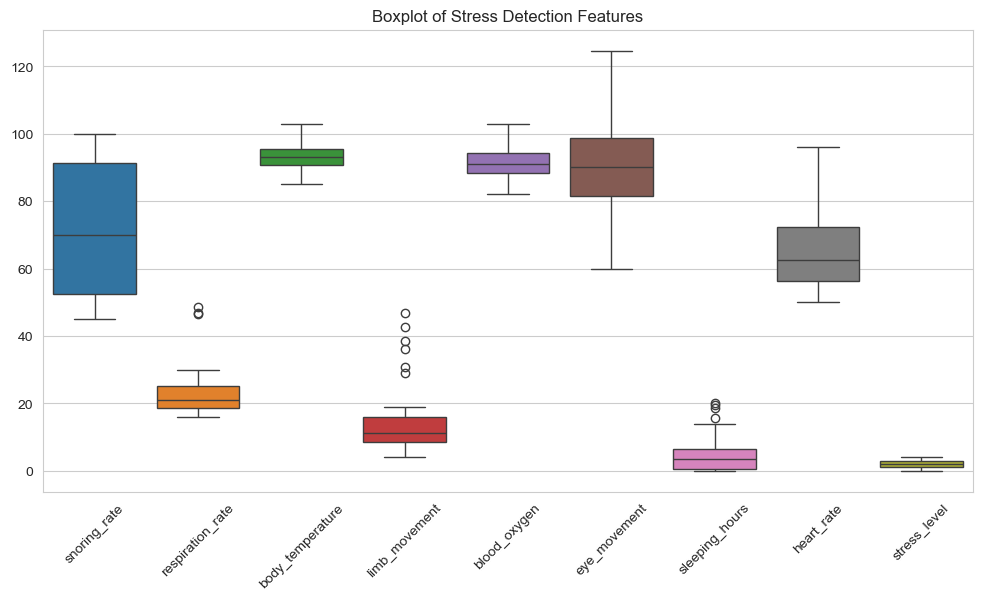

In [51]:
sns.set_style("whitegrid")
plt.figure(figsize=(12, 6))
sns.boxplot(data=df)
plt.xticks(rotation=45)
plt.title("Boxplot of Stress Detection Features")
plt.show()

## Descriptive Statistics

In [53]:
df.describe()

,snoring_rate,respiration_rate,body_temperature,limb_movement,blood_oxygen,eye_movement,sleeping_hours,heart_rate,stress_level
count,630.000000,630.000000,630.000000,630.000000,630.000000,630.000000,630.000000,630.000000,630.000000
mean,71.600000,21.916314,92.951733,11.928098,90.925076,88.743302,3.831765,64.606508,2.000000
std,19.372833,4.336242,3.619973,4.954834,3.949561,12.108409,3.312105,10.013359,1.415337
min,45.000000,16.000000,85.000000,4.000000,82.000000,60.000000,0.000000,50.000000,0.000000
25%,52.500000,18.500000,90.660000,8.564000,88.500000,81.410000,0.516000,56.450000,1.000000
50%,70.000000,21.016000,93.080000,11.048000,91.000000,90.080000,3.608000,62.540000,2.000000
75%,91.250000,25.064000,95.532000,15.830000,94.250000,98.710000,6.548000,72.260000,3.000000
max,100.000000,48.560000,102.840000,46.800000,102.875000,124.660000,20.220000,95.975000,4.000000


In [54]:
df["stress_level"].value_counts()

stress_level
3    126
1    126
0    126
2    126
4    126
Name: count, dtype: int64

In [55]:
df.corr()

,snoring_rate,respiration_rate,body_temperature,limb_movement,blood_oxygen,eye_movement,sleeping_hours,heart_rate,stress_level
snoring_rate,1.000000,0.905672,-0.808273,0.827464,-0.882360,0.895499,-0.844455,0.927907,0.975322
respiration_rate,0.905672,1.000000,-0.735787,0.768604,-0.806599,0.823448,-0.770070,0.875359,0.893639
body_temperature,-0.808273,-0.735787,1.000000,-0.685052,0.882107,-0.720650,0.788783,-0.762959,-0.864411
limb_movement,0.827464,0.768604,-0.685052,1.000000,-0.751516,0.760464,-0.709198,0.790927,0.821295
blood_oxygen,-0.882360,-0.806599,0.882107,-0.751516,1.000000,-0.791391,0.852912,-0.833774,-0.941144
eye_movement,0.895499,0.823448,-0.720650,0.760464,-0.791391,1.000000,-0.771200,0.841092,0.899183
sleeping_hours,-0.844455,-0.770070,0.788783,-0.709198,0.852912,-0.771200,1.000000,-0.791567,-0.891761
heart_rate,0.927907,0.875359,-0.762959,0.790927,-0.833774,0.841092,-0.791567,1.000000,0.919268
stress_level,0.975322,0.893639,-0.864411,0.821295,-0.941144,0.899183,-0.891761,0.919268,1.000000


## Descriptive statistics of each stress level

In [57]:
df.groupby("stress_level").describe().T[0:8]

stress_level                 0          1           2           3           4
snoring_rate count  126.000000  126.00000  126.000000  126.000000  126.000000
             mean    47.500000   55.00000   70.000000   87.500000   98.000000
             std      1.460685    2.92137    5.842739    4.382054    1.168548
             min     45.000000   50.00000   60.000000   80.000000   96.000000
             25%     46.250000   52.50000   65.000000   83.750000   97.000000
             50%     47.500000   55.00000   70.000000   87.500000   98.000000
             75%     48.750000   57.50000   75.000000   91.250000   99.000000
             max     50.000000   60.00000   80.000000   95.000000  100.000000

In [58]:
df.groupby("stress_level").describe().T[8:16]

stress_level                     0           1           2           3  \
respiration_rate count  126.000000  126.000000  126.000000  126.000000   
                 mean    17.000000   19.000000   21.202698   24.378873   
                 std      0.584274    0.584274    2.345623    3.193225   
                 min     16.000000   18.000000   20.000000   22.000000   
                 25%     16.500000   18.500000   20.500000   23.032000   
                 50%     17.000000   19.000000   21.016000   24.032000   
                 75%     17.500000   19.500000   21.516000   25.032000   
                 max     18.000000   20.000000   46.500000   48.560000   

stress_level                     4  
respiration_rate count  126.000000  
                 mean    28.000000  
                 std      1.168548  
                 min     26.000000  
                 25%     27.000000  
                 50%     28.000000  
                 75%     29.000000  
                 max     30.000000

In [59]:
df.groupby("stress_level").describe().T[16:24]

stress_level                     0          1           2           3  \
body_temperature count  126.000000  126.00000  126.000000  126.000000   
                 mean    97.286095   95.03054   93.073841   91.242476   
                 std      1.276611    0.94384    1.052840    1.613882   
                 min     93.080000   93.08000   92.000000   90.000000   
                 25%     96.606000   94.46800   92.500000   90.532000   
                 50%     97.428000   94.98400   93.016000   91.048000   
                 75%     98.202000   95.51600   93.516000   91.548000   
                 max     99.000000  102.84000  102.840000  102.840000   

stress_level                     4  
body_temperature count  126.000000  
                 mean    88.125714  
                 std      3.158631  
                 min     85.000000  
                 25%     86.250000  
                 50%     87.700000  
                 75%     89.030000  
                 max    102.840000

In [60]:
df.groupby("stress_level").describe().T[24:32]

stress_level                  0           1           2           3  \
limb_movement count  126.000000  126.000000  126.000000  126.000000   
              mean     6.392968    9.303698   11.161905   14.722175   
              std      3.149903    3.059950    1.845595    2.921422   
              min      4.000000    8.000000   10.000000   11.048000   
              25%      5.064000    8.516000   10.516000   13.210000   
              50%      6.064000    9.032000   11.044000   14.460000   
              75%      7.064000    9.532000   11.500000   15.790000   
              max     36.230000   42.650000   30.680000   38.460000   

stress_level                  4  
limb_movement count  126.000000  
              mean    18.059746  
              std      2.850811  
              min     11.048000  
              25%     17.452000  
              50%     17.984000  
              75%     18.500000  
              max     46.800000

In [61]:
df.groupby("stress_level").describe().T[32:40]

stress_level                 0           1           2           3           4
blood_oxygen count  126.000000  126.000000  126.000000  126.000000  126.000000
             mean    95.956825   93.468635   91.080659   89.119262   85.000000
             std      0.733450    0.894560    1.204638    1.375234    1.752822
             min     91.000000   91.000000   90.000000   88.000000   82.000000
             25%     95.484000   92.726000   90.500000   88.500000   83.500000
             50%     95.984000   93.476000   90.996000   89.016000   85.000000
             75%     96.500000   94.226000   91.484000   89.516000   86.500000
             max     97.000000   95.000000  102.875000  102.875000   88.000000

In [62]:
df.groupby("stress_level").describe().T[40:48]

stress_level                 0           1           2           3           4
eye_movement count  126.000000  126.000000  126.000000  126.000000  126.000000
             mean    70.422857   83.876508   90.000000   97.185714  102.231429
             std      6.579303    7.579513    2.853837    2.035829    2.390368
             min     60.000000   80.000000   85.000000   90.080000   90.080000
             25%     65.000000   81.290000   87.660000   96.090000  101.170000
             50%     70.160000   82.580000   90.080000   97.340000  102.500000
             75%     75.320000   83.870000   92.420000   98.670000  103.750000
             max     90.080000  124.660000   95.000000  100.000000  105.000000

In [63]:
df.groupby("stress_level").describe().T[48:56]

stress_level                   0           1           2           3  \
sleeping_hours count  126.000000  126.000000  126.000000  126.000000   
               mean     8.058444    5.984762    3.911175    1.175810   
               std      1.344759    0.620591    2.521428    1.473166   
               min      3.608000    3.608000    2.000000    0.000000   
               25%      7.484000    5.484000    2.750000    0.500000   
               50%      8.000000    6.000000    3.608000    1.032000   
               75%      8.500000    6.500000    4.298000    1.548000   
               max     18.600000    7.000000   20.220000   15.600000   

stress_level                   4  
sleeping_hours count  126.000000  
               mean     0.028635  
               std      0.321426  
               min      0.000000  
               25%      0.000000  
               50%      0.000000  
               75%      0.000000  
               max      3.608000

In [64]:
df.groupby("stress_level").describe().T[56:64]

stress_level               0           1           2           3           4
heart_rate count  126.000000  126.000000  126.000000  126.000000  126.000000
           mean    52.926825   57.917421   62.781548   70.005198   79.401548
           std      2.434069    3.791208    3.283409    3.926492    4.696873
           min     50.000000   55.000000   60.040000   62.540000   62.540000
           25%     51.330000   56.250000   61.410000   67.260000   77.180000
           50%     52.660000   57.580000   62.540000   70.000000   79.760000
           75%     53.950000   58.870000   63.670000   72.500000   82.420000
           max     62.540000   95.975000   95.975000   95.975000   95.975000

## Creating train & test data

In [66]:
train, test = train_test_split(df,test_size=0.25,random_state=101)

## Data augmentation

In [68]:
# Simple Augmentation Functions (for all numeric columns)
def augment_data(train, noise_level=0.01, scale_range=(0.9, 1.1)):
    train_aug = train.copy()
    
    # Apply only on numeric columns (skip label or non-numeric columns)
    numeric_cols = train.select_dtypes(include=[np.number]).columns

    np.random.seed(1)
    for col in numeric_cols:
        # Add noise (jittering)
        train_aug[col] += np.random.normal(0, noise_level, size=len(train))

        # Scale up/down slightly
        scale_factor = np.random.uniform(scale_range[0], scale_range[1])
        train_aug[col] *= scale_factor

    return train_aug

# Apply augmentation
df_augmented = augment_data(train)

# Combine original + augmented data
df_combined = pd.concat([train, df_augmented], ignore_index=True)

# Check result
df_combined

,snoring_rate,respiration_rate,body_temperature,limb_movement,blood_oxygen,eye_movement,sleeping_hours,heart_rate,stress_level
0,58.640000,19.728000,95.728000,9.728000,94.592000,84.320000,6.728000,59.320000,1.000000
1,86.840000,23.824000,90.912000,14.280000,88.912000,97.280000,0.912000,69.560000,3.000000
2,68.800000,20.880000,92.880000,10.880000,90.880000,89.400000,3.320000,62.200000,2.000000
3,70.400000,21.040000,93.040000,11.040000,91.040000,90.080000,3.560000,62.600000,2.000000
4,81.440000,22.384000,90.192000,12.480000,88.192000,90.080000,0.192000,65.960000,3.000000
...,...,...,...,...,...,...,...,...,...
939,102.073656,30.310190,85.687401,17.179341,81.734984,103.361347,-0.006726,83.355909,4.049517
940,103.430411,31.735981,87.308647,17.805162,83.631845,105.009383,-0.012438,86.752706,4.061769
941,100.384044,28.576265,83.758905,16.414526,79.449259,101.332413,0.001025,79.183956,4.050306
942,49.486411,18.406434,95.497946,5.730641,92.308823,70.646866,7.229894,54.683172,-0.008323


In [69]:
# Checking distribution of stress levels
a=df_combined["stress_level"]
a=a.astype(int)
a.value_counts()

stress_level
4    198
2    194
0    193
3    180
1    179
Name: count, dtype: int64

## Model fitting and evaluation

In [71]:
Y_train = df_combined["stress_level"]
X_train = df_combined.drop(["stress_level"], axis= 1)
Y_test = test["stress_level"]
X_test = test.drop(["stress_level"], axis= 1)

In [72]:
Y_train=Y_train.astype(int)

In [73]:
print("X_train shape is",X_train.shape)
print("X_test shape is",X_test.shape)
print("Y_train shape is",Y_train.shape)
print("Y_test shape is",Y_test.shape)

X_train shape is (944, 8)
X_test shape is (158, 8)
Y_train shape is (944,)
Y_test shape is (158,)


### Hyperparameter tuning

#### K-Nearest Neighbours

In [90]:
# Define parameter grid
param_grid = {
    "n_neighbors": range(1, 31),
    "weights": ["uniform", "distance"],  
    "metric": ["euclidean", "manhattan", "minkowski"]
}

# Initialize KNN model
knn = KNeighborsClassifier()

# Perform GridSearchCV
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring="accuracy", n_jobs=-1, verbose=2)
grid_search.fit(X_train, Y_train)

# Best parameters
print("Best Parameters:", grid_search.best_params_)

Fitting 5 folds for each of 180 candidates, totalling 900 fits
Best Parameters: {'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'uniform'}


#### Random Forest

In [124]:
# Define the parameter grid 
param_dist = {
    "n_estimators": np.arange(100, 1000, 50), 
    "max_depth": np.arange(5, 50, 2),  
    "min_samples_split": np.arange(1, 20),  
    "min_samples_leaf": np.arange(1, 10),  
    "max_features": ["sqrt", "log2", None],  
    "bootstrap": [True, False]  
}

# Create Random Forest model
rf = RandomForestClassifier(random_state=42)

# RandomizedSearchCV 
random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_dist, n_iter=20, cv=5, scoring='accuracy', 
                                      n_jobs=-1, verbose=2, random_state=42)

# Fit the model
random_search.fit(X_train, Y_train)

# Best parameters
print("Best Parameters:", random_search.best_params_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Parameters: {'n_estimators': 750, 'min_samples_split': 7, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 19, 'bootstrap': False}


#### Support Vector Classifier

In [99]:
# Define the parameter grid
param_grid = {
    "C": [0.1, 1, 10],  
    "kernel": ["linear", "rbf"],  
    "gamma": ["scale", "auto", 0.01, 0.1]
}

# Initialize SVC
svc = SVC()

# Perform Grid Search
grid_search = GridSearchCV(svc, param_grid, cv=5, scoring="accuracy", n_jobs=-1, verbose=1)

# Fit model
grid_search.fit(X_train, Y_train)

# Best Parameters
print("Best Parameters:", grid_search.best_params_)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best Parameters: {'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}


#### CatBoost Classifier

In [190]:
# Define parameter grid
param_grid = {
    "iterations": [200, 500], 
    "learning_rate": [0.03, 0.1],  
    "depth": [4, 6, 8],  
    "l2_leaf_reg": [1, 3, 5],  
}

# Initialize CatBoostClassifier
catboost = CatBoostClassifier(verbose=0)

# Perform Grid Search
grid_search = GridSearchCV(catboost, param_grid, cv=5, scoring="accuracy", n_jobs=-1, verbose=2)
grid_search.fit(X_train, Y_train)

# Best parameters
print("Best Parameters:", grid_search.best_params_)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best Parameters: {'depth': 8, 'iterations': 200, 'l2_leaf_reg': 1, 'learning_rate': 0.03}


### Model fitting

In [104]:
models = {
    "SVC": SVC(kernel='rbf', C=1, gamma=0.01),
    "KNN": KNeighborsClassifier(metric="manhattan", n_neighbors=5, weights="uniform"),
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(n_estimators=750, criterion='gini', max_features="sqrt", min_samples_split=7, 
                                            min_samples_leaf=4, max_depth=19, random_state=42),
    "Naive Bayes": GaussianNB(),
    "CatBoost": CatBoostClassifier(random_state=42, iterations=200, depth=8, learning_rate=0.03, l2_leaf_reg=1)
}

accuracy_results = []
for name, model in models.items():
    model.fit(X_train, Y_train)
    Y_pred_train = model.predict(X_train)
    Y_pred_test = model.predict(X_test)
    train_accuracy = accuracy_score(Y_train, Y_pred_train)
    test_accuracy = accuracy_score(Y_test, Y_pred_test)
    accuracy_results.append([name, train_accuracy, test_accuracy])

C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0:	learn: 1.5118095	total: 278ms	remaining: 55.2s
1:	learn: 1.4251454	total: 338ms	remaining: 33.4s
2:	learn: 1.3472667	total: 396ms	remaining: 26s
3:	learn: 1.2780060	total: 449ms	remaining: 22s
4:	learn: 1.2113925	total: 489ms	remaining: 19.1s
5:	learn: 1.1517758	total: 528ms	remaining: 17.1s
6:	learn: 1.0968555	total: 565ms	remaining: 15.6s
7:	learn: 1.0459552	total: 603ms	remaining: 14.5s
8:	learn: 0.9975863	total: 641ms	remaining: 13.6s
9:	learn: 0.9552527	total: 679ms	remaining: 12.9s
10:	learn: 0.9169212	total: 718ms	remaining: 12.3s
11:	learn: 0.8797469	total: 755ms	remaining: 11.8s
12:	learn: 0.8445233	total: 793ms	remaining: 11.4s
13:	learn: 0.8111654	total: 831ms	remaining: 11s
14:	learn: 0.7814804	total: 867ms	remaining: 10.7s
15:	learn: 0.7524660	total: 905ms	remaining: 10.4s
16:	learn: 0.7242023	total: 942ms	remaining: 10.1s
17:	learn: 0.6980093	total: 982ms	remaining: 9.93s
18:	learn: 0.6739389	total: 1.04s	remaining: 9.9s
19:	learn: 0.6491078	total: 1.09s	remaining: 9.8

In [105]:
pd.DataFrame(accuracy_results,columns=["model","Train Accuracy","Test Accuracy"])

,model,Train Accuracy,Test Accuracy
0,SVC,0.993644,0.974684
1,KNN,0.993644,1.000000
2,Logistic Regression,0.978814,0.955696
3,Random Forest,0.994703,0.993671
4,Naive Bayes,0.978814,0.962025
5,CatBoost,0.994703,0.987342


## Cross-Validation

In [ ]:
# Perform cross-validation for each model
cv_results = {}

for name, model in models.items():
    scores = cross_val_score(model, X_train, Y_train, cv=5, scoring="accuracy", n_jobs=-1)
    cv_results[name] = (np.mean(scores), np.std(scores))
    print(f"{name}: Mean Accuracy = {np.mean(scores):.4f} ± {np.std(scores):.4f}")

SVC: Mean Accuracy = 0.9883 ± 0.0091
KNN: Mean Accuracy = 0.9936 ± 0.0085
Logistic Regression: Mean Accuracy = 0.9650 ± 0.0110
Random Forest: Mean Accuracy = 0.9936 ± 0.0085
Naive Bayes: Mean Accuracy = 0.9608 ± 0.0179


## Model Comparison

In [ ]:
pd.DataFrame({"Model":["KNN","RandomForest","Logistic","SVC","NaiveBayes","CatBoost"],
              "Train Accuracy":[99.36,99.47,97.88,99.36,97.88,99.47],"Test Accuracy":[1.00,99.37,95.57,97.47,96.20,98.73],
              "Cross Validation":[99.36,99.36,96.50,98.83,96.08,99.47]})

### Classification report

In [ ]:
# Initialize a table
table = PrettyTable()
table.field_names = ["Model", "Class", "Precision", "Recall", "F1-score"]

for name, model in models.items():
    Y_pred = model.predict(X_test)
    report = classification_report(Y_test, Y_pred, output_dict=True)
    
    # Iterate over class-wise metrics
    for cls in range(5):  # Assuming stress levels 0-4
        precision = round(report[str(cls)]["precision"], 2)
        recall = round(report[str(cls)]["recall"], 2)
        f1 = round(report[str(cls)]["f1-score"], 2)
        table.add_row([name, cls, precision, recall, f1])
    table.add_row(["-" * 10, "-" * 5, "-" * 9, "-" * 6, "-" * 8])

# Print formatted table
print("\nClassification Report Summary:\n")
print(table)

### Confusion matrix

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10)) 
axes = axes.flatten()

for idx, (name, model) in enumerate(models.items()):
    Y_pred = model.predict(X_test)
    cm = confusion_matrix(Y_test, Y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="flare", ax=axes[idx])
    axes[idx].set_title(f"Confusion Matrix - {name}")
    axes[idx].set_xlabel("Predicted Label")
    axes[idx].set_ylabel("True Label")

plt.subplots_adjust(wspace=0.3, hspace=0.4)
plt.show()

### Visual comparison

In [ ]:
# Define models and their respective performance metrics
models = ["SVC", "KNN", "Logistic Regression", "Naive Bayes", "Random Forest", "CatBoost"]
accuracy = [97.47, 100, 95.57, 96.2, 99.37, 98.73]
precision = [97.8, 100, 96, 96.4, 99.4, 98.8]
recall = [97.6, 100, 95.6, 96.2, 99.4, 98.8]
f1_score = [97.6, 100, 95.6, 96.4, 99.4, 98.8]

# Convert to NumPy array for easier manipulation
metrics = np.array([accuracy, precision, recall, f1_score])

# Define bar width and x-axis positions
bar_width = 0.2
x = np.arange(len(models))

# Plot grouped bars
plt.figure(figsize=(10, 6))
plt.bar(x - 1.5*bar_width, accuracy, width=bar_width, label="Accuracy", color="skyblue")
plt.bar(x - 0.5*bar_width, precision, width=bar_width, label="Precision", color="lightcoral")
plt.bar(x + 0.5*bar_width, recall, width=bar_width, label="Recall", color="gold")
plt.bar(x + 1.5*bar_width, f1_score, width=bar_width, label="F1-Score", color="lightgreen")

# Add labels and title
plt.xlabel("Models")
plt.ylabel("Performance (%)")
plt.title("Model Performance Comparison")
plt.xticks(ticks=x, labels=models, rotation=30)
plt.ylim(90, 102)
plt.legend()
plt.show()